### Librairies import
https://paperswithcode.com/task/few-shot-image-segmentation

In [7]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import sklearn.metrics
import skimage.io
from sklearn.cluster import KMeans

from scipy import ndimage as ndi
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
from skimage.filters import rank
from skimage.morphology import disk
import sklearn.metrics

from pathlib import Path


### Datasets import

In [2]:
from utils import get_data, plot_slice_seg, rand_index_dataset, prediction_to_df, df_get_ith_image

In [4]:
X_train, X_test, y_train = get_data()

ValueError: invalid literal for int() with base 10: "' filemode='drwxr-xr-x'>"

In [8]:
data_dir = Path("C:/Users/arist/challenge_ens/Datasets/")
y_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

def load_dataset(dataset_dir):
    dataset_list = []
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), 
                                  key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

X_train = load_dataset(data_dir/"X_train/images")
X_test = load_dataset(data_dir/"X_test/images")

### K means algorithm

In [9]:
# Let's create a validation set first: the 200 first images of the train set 
data_val = X_train[:200]
labels_val = y_train.iloc[:200]

In [10]:
def k_means(data, k):
    s = 0
    predictions = []
    
    for image in data:
        flatten_image = image.reshape(image.shape[0] * image.shape[1], 1)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(flatten_image)
        clustered = kmeans.cluster_centers_[kmeans.labels_]
        predictions.append(clustered)
        s = s+1
        if s%20 == 0:
            print(f'Image {s}/{data.shape[0]}')
            
    return predictions

In [11]:
predictions = k_means(data_val, 6)

Image 20/200
Image 40/200
Image 60/200
Image 80/200
Image 100/200
Image 120/200
Image 140/200
Image 160/200
Image 180/200
Image 200/200


In [12]:
np.round(predictions[0])

array([[15.],
       [15.],
       [15.],
       ...,
       [15.],
       [15.],
       [15.]])

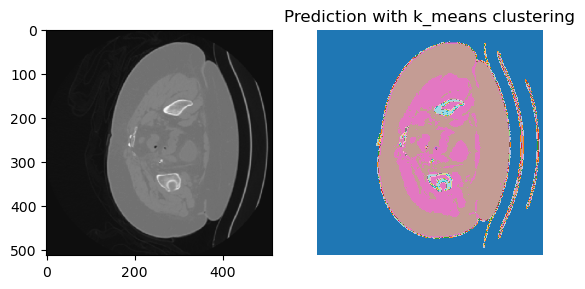

In [13]:
plot_slice_seg(data_val[0], predictions[0])
plt.title('Prediction with k_means clustering');

With the k means clustering, values of cluster colors are float, but the evaluation metrics only accept int values, so we need to convert the pixel to int values

In [14]:
predictions_df = prediction_to_df(np.round(predictions))

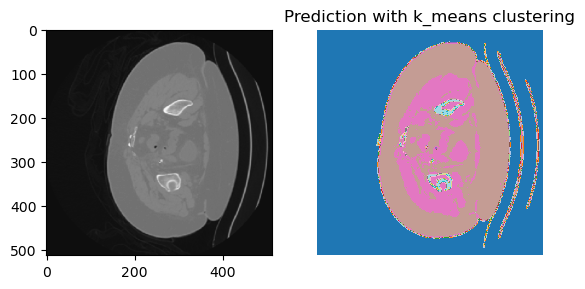

In [15]:
plot_slice_seg(data_val[0], df_get_ith_image(predictions_df, 0))
plt.title('Prediction with k_means clustering');

We notice that the segmentation between brain parts and background is very good, but there's no homogeneity at all within clusters

In [16]:
round_pred1 = df_get_ith_image(predictions_df, 0)
background1 = np.max(round_pred1)
for x in range(512):
    for y in range(512):
        if round_pred1[x, y] != 0:
            round_pred1[x, y] = 155.
            
round_pred2 = df_get_ith_image(predictions_df, 20)
for x in range(512):
    for y in range(512):
        if round_pred2[x, y] != 0:
            round_pred2[x, y] = 155.

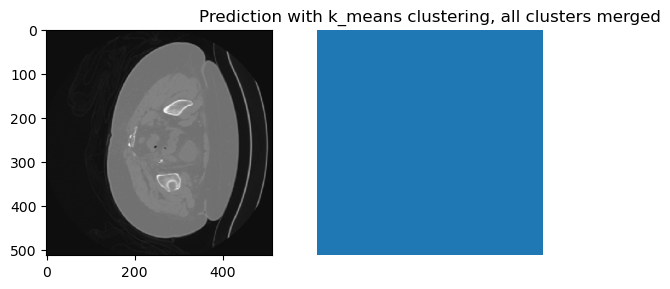

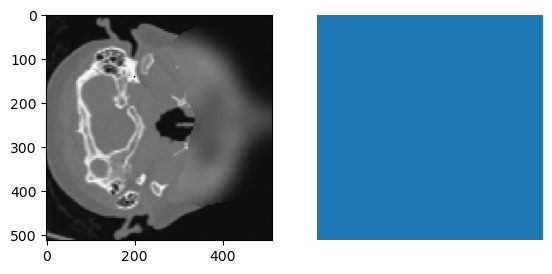

In [17]:
plot_slice_seg(data_val[0], round_pred1)
plt.title('Prediction with k_means clustering, all clusters merged')
plot_slice_seg(data_val[20], round_pred2)

Let's compute the scores of the k_means algo, and the k_means with merged clusters

In [18]:
score_k_means = rand_index_dataset(labels_val, predictions_df.sample(200))

In [19]:
s = 0
merged_clusters_pred = predictions_df.copy()
#for index in range(len(merged_clusters_pred)):
for index in range(len(merged_clusters_pred)):
    image = df_get_ith_image(merged_clusters_pred, index)
    for x in range(512):
        for y in range(512):
            if image[x, y] != 0:
                image[x, y] = 155
    s = s+1
    if s%20 == 0:
        print(f'Clusters of image {s}/200 merged')

Clusters of image 20/200 merged
Clusters of image 40/200 merged
Clusters of image 60/200 merged
Clusters of image 80/200 merged
Clusters of image 100/200 merged
Clusters of image 120/200 merged
Clusters of image 140/200 merged
Clusters of image 160/200 merged
Clusters of image 180/200 merged
Clusters of image 200/200 merged


In [20]:
score_merged_k_means = rand_index_dataset(labels_val, merged_clusters_pred.sample(200))

In [21]:
print(f"The score with k_means in {score_k_means}")
print(f"The score with merged k_means is {score_merged_k_means}")

The score with k_means in 0.0687503285953583
The score with merged k_means is 0.05114830536950715


We notice that even though the score is very low,  the separation with the background done by k_means is very good. We'll try to se the watershed algorithm on the output of the k means algo

### Watershed on k_means output

We'll use the same code than the one provided in the baseline

In [22]:
def compute_baseline_one_sample(data_slice):
    data_slice = skimage.util.img_as_ubyte(data_slice)
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

In [23]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        data_slice = skimage.util.img_as_ubyte(data_slice)
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

We convert the k_means predictions to arrays, in order to use the watershed algorithm

In [24]:
data_val_k_means = np.array(predictions_df).reshape(200, 512, 512).astype(int)
data_val_merged_k_means = np.array(merged_clusters_pred).reshape(200, 512, 512).astype(int)

In [25]:
watershed_k_means = compute_baseline(data_val_k_means)

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\arist\anaconda3\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 155 fits in uint8
  return _convert(image, np.uint8, force_copy)
  0%|          | 1/200 [00:00<01:08,  2.91it/s]c:\Users\arist\anaconda3\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 244 fits in uint8
  return _convert(image, np.uint8, force_copy)
  1%|          | 2/200 [00:00<01:04,  3.05it/s]c:\Users\arist\anaconda3\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 110 fits in uint8
  return _convert(image, np.uint8, force_copy)
  2%|▏         | 3/200 [00:01<01:12,  2.73it/s]c:\Users\arist\anaconda3\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 197 fits in uint8
  return _convert(image, np.uin

In [26]:
watershed_merged_k_means = compute_baseline(data_val_merged_k_means)

100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


In [27]:
watershed = compute_baseline(data_val)

100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


We plot the different predictions :

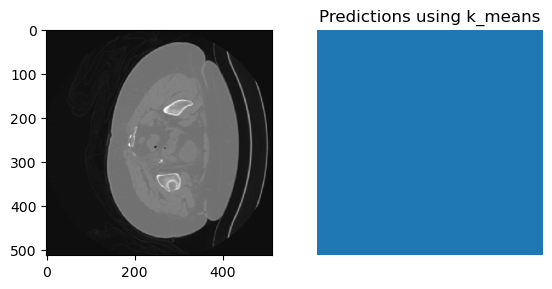

In [28]:
plot_slice_seg(data_val[0], data_val_merged_k_means[0])
plt.title('Predictions using k_means');

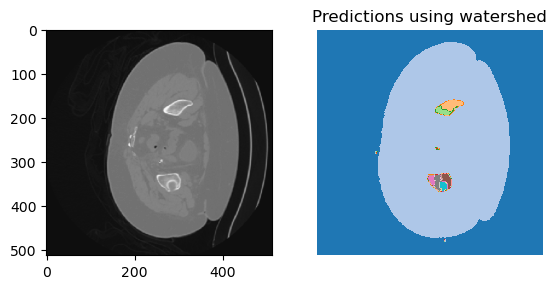

In [29]:
plot_slice_seg(data_val[0], df_get_ith_image(watershed, 0))
plt.title('Predictions using watershed');

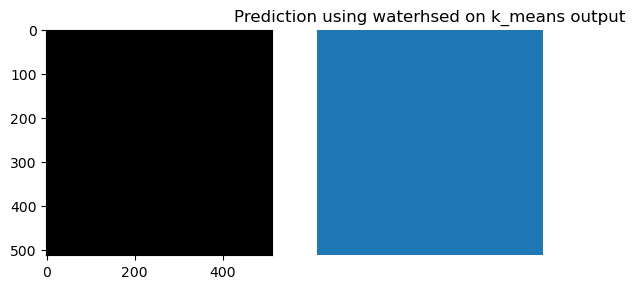

In [30]:
plot_slice_seg(data_val_k_means[0], df_get_ith_image(watershed_k_means, 0))
plt.title('Prediction using waterhsed on k_means output');

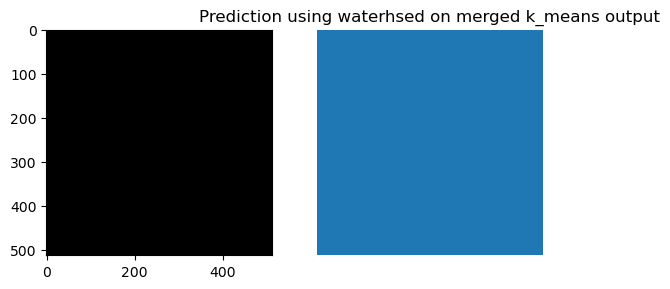

In [31]:
plot_slice_seg(data_val_merged_k_means[0], df_get_ith_image(watershed_merged_k_means, 0))
plt.title('Prediction using waterhsed on merged k_means output');

In [32]:
score_watershed = rand_index_dataset(labels_val, watershed)
score_watershed_k_means = rand_index_dataset(labels_val, watershed_k_means)
score_watershed_merged_k_means = rand_index_dataset(labels_val, watershed_merged_k_means)

In [33]:
print(f"The score with watershed is {score_watershed}")
print(f"The score with watershed k_means is {score_watershed_k_means}")
print(f"The score with watershed merged k_means is {score_watershed_merged_k_means}")

The score with watershed is 0.270633377755745
The score with watershed k_means is 0.2719535726896674
The score with watershed merged k_means is 0.05549551361385194


We see no difference, except that watershed after k_means is very slightly better